In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report 
import tensorflow as tf
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input

batch_size = 128

In [26]:
seed = 666
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)                      
random.seed(666)

In [27]:
os.listdir("../input/dogs-vs-cats/")



['test1.zip', 'train.zip', 'sampleSubmission.csv']

In [28]:
TRAIN_PATH = "../input/dogs-vs-cats/train.zip"
TEST_PATH = "../input/dogs-vs-cats/test1.zip"

FILES = "/kaggle/files/unzipped/"

with zipfile.ZipFile(TRAIN_PATH, 'r') as zipp:
    zipp.extractall(FILES)
    
with zipfile.ZipFile(TEST_PATH, 'r') as zipp:
    zipp.extractall(FILES)

In [29]:
train_df = pd.DataFrame({"file": os.listdir("/kaggle/files/unzipped/train")})
train_df["label"] = train_df["file"].apply(lambda x: x.split(".")[0])

train_df.head()

,file,label
0,dog.890.jpg,dog
1,dog.1178.jpg,dog
2,dog.7845.jpg,dog
3,dog.4632.jpg,dog
4,cat.3660.jpg,cat


In [30]:
test_df = pd.DataFrame({"file": os.listdir("/kaggle/files/unzipped/test1")})

test_df.head()

,file
0,10435.jpg
1,6790.jpg
2,4644.jpg
3,1835.jpg
4,1102.jpg


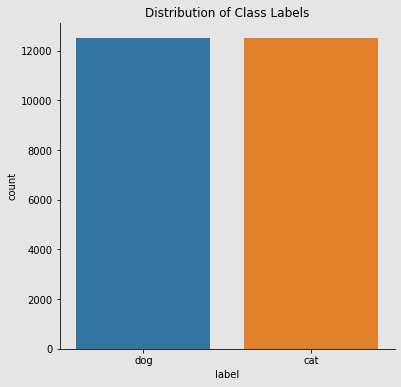

In [31]:
fig, ax = plt.subplots(figsize = (6, 6), facecolor = "#e5e5e5")
ax.set_facecolor("#e5e5e5")

sns.countplot(x = "label", data = train_df, ax = ax)

ax.set_title("Distribution of Class Labels")
sns.despine()
plt.show()

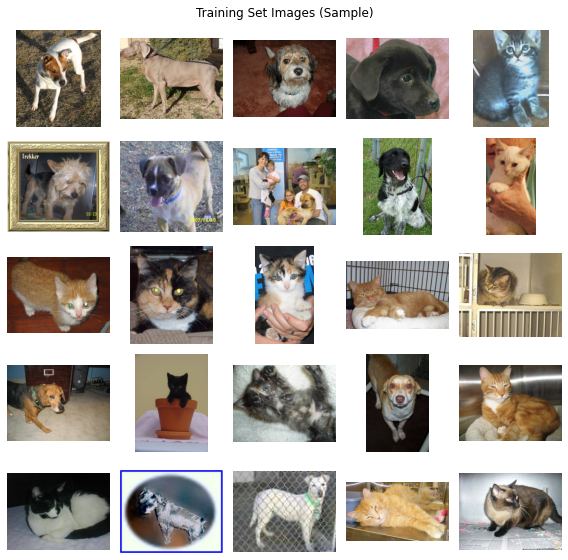

In [32]:
fig = plt.figure(1, figsize = (8, 8))
fig.suptitle("Training Set Images (Sample)")

for i in range(25):

    plt.subplot(5, 5, i + 1)
    image = load_img(FILES + "train/" + train_df["file"][i])
    plt.imshow(image)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

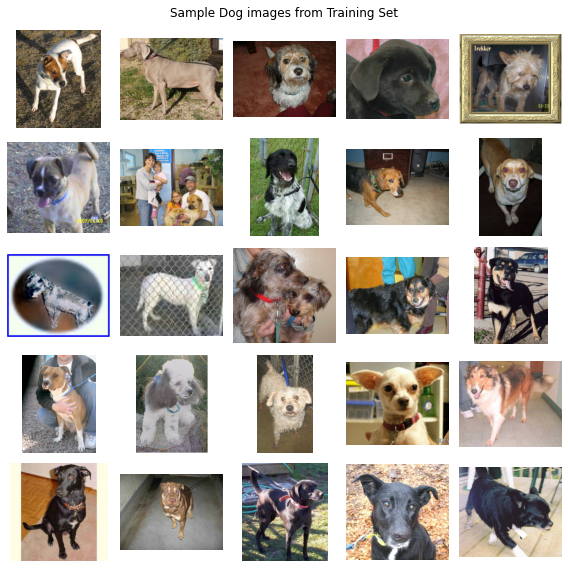

In [33]:
fig = plt.figure(1, figsize = (8, 8))
fig.suptitle("Sample Dog images from Training Set")

for i in range(25):
    
    plt.subplot(5, 5, i + 1)
    image = load_img(FILES + "train/" + train_df.query("label == 'dog'").file.values[i])
    plt.imshow(image)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

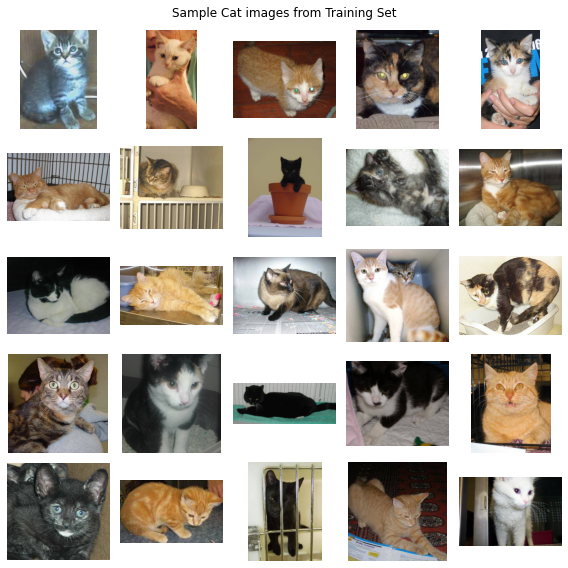

In [34]:
fig = plt.figure(1, figsize = (8, 8))
fig.suptitle("Sample Cat images from Training Set")

for i in range(25):
    
    plt.subplot(5, 5, i + 1)
    image = load_img(FILES + "train/" + train_df.query("label == 'cat'").file.values[i])
    plt.imshow(image)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [35]:
train_data, val_data = train_test_split(train_df, 
                                        test_size = 0.2, 
                                        stratify = train_df["label"], 
                                        random_state = 666)

Found 1 validated image filenames belonging to 1 classes.


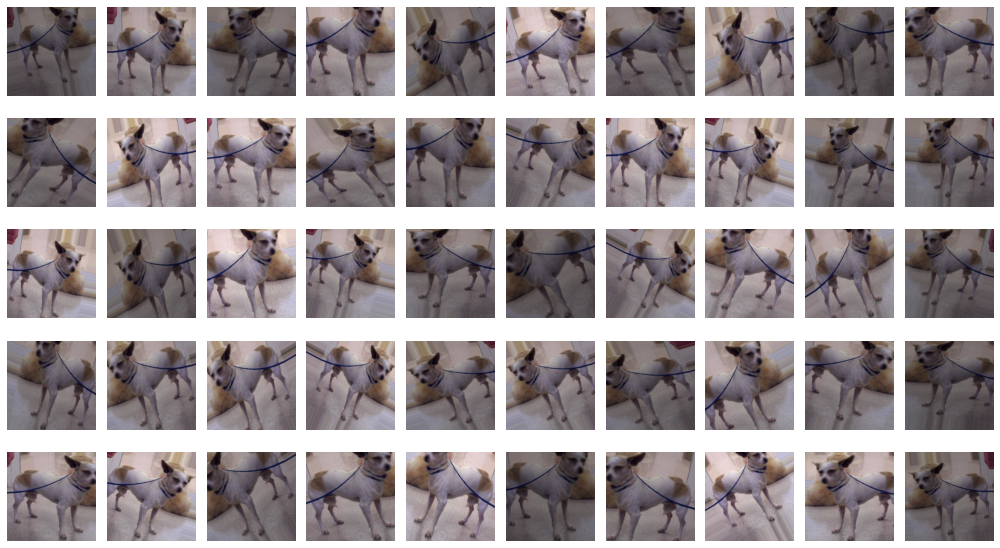

In [36]:
datagen = ImageDataGenerator(
    rotation_range = 30, 
    width_shift_range = 0.1,
    height_shift_range = 0.1, 
    brightness_range = (0.5, 1), 
    zoom_range = 0.2,
    horizontal_flip = True, 
    rescale = 1./255,
)

sample_df = train_data.sample(1)

sample_generator = datagen.flow_from_dataframe(
    dataframe = sample_df,
    directory = FILES + "train/",
    x_col = "file",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224, 224),
    seed = 666
)

plt.figure(figsize = (14, 8))

for i in range(50):
    
    plt.subplot(5, 10, i + 1)
    
    for X, y in sample_generator:

        plt.imshow(X[0])
        plt.axis("off")
        break
        
plt.tight_layout()
plt.show()

In [37]:
train_datagen = ImageDataGenerator(
    rotation_range = 15, 
#     width_shift_range = 0.1,
#     height_shift_range = 0.1, 
#     brightness_range = (0.5, 1), 
#     zoom_range = 0.1,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [38]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = FILES + "train/",
    x_col = "file",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 666,
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = FILES + "train/",
    x_col = "file",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 666,
    shuffle = False
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [39]:
from keras.applications.vgg16 import VGG16
from keras.models import Model


input_shape=(224,224,3)
batch_size= 128

base_model = VGG16(
    weights = "imagenet", 
    input_shape = (224, 224, 3),
    include_top = False
)

for layer in base_model.layers:
    layer.trainable = False
    
def vgg16_pretrained():
    
    model= Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(100,activation='relu'),
        Dropout(0.4),
        Dense(64,activation='relu'),
        Dense(2,activation='softmax')
    ])
    
    return model


tf.keras.backend.clear_session()

In [40]:
model = vgg16_pretrained()

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "accuracy")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 14,772,582
Trainable params: 57,894
Non-trainable params: 14,714,688
_______________________________________

In [41]:
reduce_lr = ReduceLROnPlateau(
    monitor = "val_accuracy", 
    patience = 2,
    verbose = 1, 
    factor = 0.5, 
    min_lr = 0.000000001
)

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    patience = 5,
    verbose = 1,
    mode = "max",
)

checkpoint = ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "catdog_vgg16_.{epoch:02d}-{val_accuracy:.6f}.hdf5",
    verbose = 1,
    save_best_only = True, 
    save_weights_only = True
)

In [42]:
history = model.fit(
    train_generator,
    epochs = 10, 
    validation_data = val_generator,
    validation_steps = val_data.shape[0] // batch_size,
    steps_per_epoch = train_data.shape[0] // batch_size,
    callbacks = [reduce_lr, early_stopping, checkpoint]
)

Epoch 1/10
156/156 [==============================] - 293s 2s/step - loss: 0.1620 - accuracy: 0.9509 - val_loss: 0.0763 - val_accuracy: 0.9770

Epoch 00001: val_accuracy improved from -inf to 0.97696, saving model to catdog_vgg16_.01-0.976963.hdf5
Epoch 2/10
156/156 [==============================] - 290s 2s/step - loss: 0.0730 - accuracy: 0.9731 - val_loss: 0.0692 - val_accuracy: 0.9806

Epoch 00002: val_accuracy improved from 0.97696 to 0.98057, saving model to catdog_vgg16_.02-0.980569.hdf5
Epoch 3/10
156/156 [==============================] - 289s 2s/step - loss: 0.0615 - accuracy: 0.9770 - val_loss: 0.0614 - val_accuracy: 0.9800

Epoch 00003: val_accuracy did not improve from 0.98057
Epoch 4/10
156/156 [==============================] - 289s 2s/step - loss: 0.0535 - accuracy: 0.9805 - val_loss: 0.0583 - val_accuracy: 0.9810

Epoch 00004: val_accuracy improved from 0.98057 to 0.98097, saving model to catdog_vgg16_.04-0.980970.hdf5
Epoch 5/10
156/156 [==============================]

In [43]:
tf.keras.backend.clear_session()

model = vgg16_pretrained()

model.load_weights("./catdog_vgg16_.10-0.983774.hdf5")

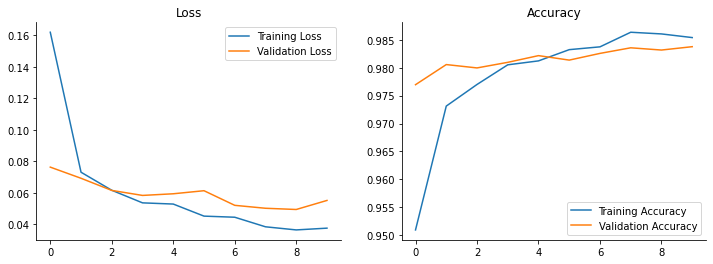

In [44]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])), y = history.history["loss"], ax = axes[0], label = "Training Loss")
sns.lineplot(x = range(len(history.history["loss"])), y = history.history["val_loss"], ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["accuracy"], ax = axes[1], label = "Training Accuracy")
sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["val_accuracy"], ax = axes[1], label = "Validation Accuracy")
axes[0].set_title("Loss"); axes[1].set_title("Accuracy")

sns.despine()
plt.show()

In [45]:
val_pred = model.predict(val_generator, steps = np.ceil(val_data.shape[0] / batch_size))
val_data.loc[:, "val_pred"] = np.argmax(val_pred, axis = 1)

labels = dict((v, k) for k, v in val_generator.class_indices.items())

val_data.loc[:, "val_pred"] = val_data.loc[:, "val_pred"].map(labels)

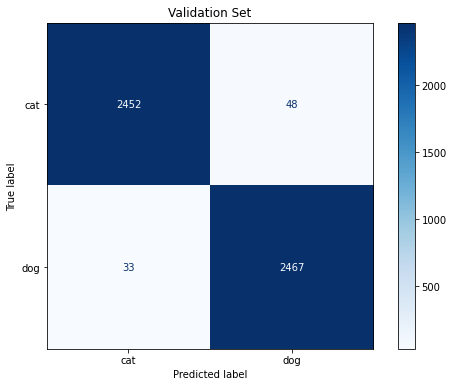

In [46]:
fig, ax = plt.subplots(figsize = (9, 6))

cm = confusion_matrix(val_data["label"], val_data["val_pred"])

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["cat", "dog"])
disp.plot(cmap = plt.cm.Blues, ax = ax)

ax.set_title("Validation Set")
plt.show()